# Open-EO Proof Of Concept: Compositing
This notebook explains and demonstrates the OpenEO client API, as well as some concepts of the core API.

The OpenEO API can be accesed with the `openeo` client Python module. The dependencies of this module are limited to a set of well known modules such as numpy and pandas. This should allow it to run in different environments, and as part of larger workflows.

Let's get started with importing the module.

In [1]:
import openeo
import logging
import pathlib

In [2]:
# logging.basicConfig(level=logging.DEBUG)

To connect with an OpenEO backend, we create a session. Each OpenEO backend has a different endpoint, metadata and credentials. A session object contains this information, and is the starting point for subsequent calls. 

In [3]:
session = openeo.session("nobody", "http://openeo.vgt.vito.be/openeo/0.4.0")

## Loading a collection

Our first use case is to create a composite image by taking the maximum pixel value over a timeseries of images.
To do this, we first need to select input data. Each OpenEO endpoint exposes it's own list of image collections.

In [5]:
session.list_collection_ids()

['CGS_SENTINEL2_RADIOMETRY_V102_001',
 'S2_FAPAR_V102_WEBMERCATOR2',
 'S2_FCOVER_PYRAMID',
 'S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID',
 'S1_GRD_SIGMA0_DESCENDING',
 'BIOPAR_FAPAR_V1_GLOBAL',
 'S1_GRD_SIGMA0_ASCENDING',
 'PROBAV_L3_S10_TOC_NDVI_333M_V2']

Let's take Sentinel-2 radiometry data.

In [6]:
collection_id = "CGS_SENTINEL2_RADIOMETRY_V102_001"
session.describe_collection(collection_id)

{'bands': [{'band_id': '2',
   'name': 'blue',
   'offset': 0,
   'res_m': 10,
   'scale': 0.0001,
   'type': 'int16',
   'unit': '1',
   'wavelength_nm': 496.6},
  {'band_id': '3',
   'name': 'green',
   'offset': 0,
   'res_m': 10,
   'scale': 0.0001,
   'type': 'int16',
   'unit': '1',
   'wavelength_nm': 560},
  {'band_id': '4',
   'name': 'red',
   'offset': 0,
   'res_m': 10,
   'scale': 0.0001,
   'type': 'int16',
   'unit': '1',
   'wavelength_nm': 664.5},
  {'band_id': '8',
   'name': 'nir',
   'offset': 0,
   'res_m': 10,
   'scale': 0.0001,
   'type': 'int16',
   'unit': '1',
   'wavelength_nm': 835.1}],
 'data_id': 'CGS_SENTINEL2_RADIOMETRY_V102_EARLY',
 'description': 'Sentinel 2 Level-2: Bottom-of-atmosphere reflectances in cartographic geometry, provided by Terrascope.',
 'extent': {'crs': 'EPSG:3857',
  'spatial': [180, -56, -180, 83],
  'temporal': ['2015-07-06', None]},
 'id': 'CGS_SENTINEL2_RADIOMETRY_V102_001',
 'license': 'free',
 'links': [{'href': 'https://terras

In the client code we create a so called image collection, which is a thin reference to this data and allows to build on that with further operations.

In [7]:
s2_radiometry = session.imagecollection(collection_id)
s2_radiometry

As the data covered by the image collection can be quite large, a first step is usually to define a spatial and temporal subset on which we want to operate. This can be done by specifying a date range and a bounding box:

In [8]:
timeseries = s2_radiometry\
.filter_temporal("2017-10-14","2017-10-17")\
.filter_bbox(west=761104,east=763281,south=6543830,north=6544655,crs="EPSG:3857")
timeseries

## Calculating NDVI

We can calculate the NDVI based on the bands of the data using standard mathematical operators.

In [9]:
band_red = timeseries.band('2')
band_nir = timeseries.band('3')
ndvi_timeseries = (band_nir - band_red) / (band_nir + band_red)
ndvi_timeseries

Now we're all set to compute the composite, the `max_time` function allows us to specify the function that needs to be applied, but does not yet compute a result:

In [10]:
composite = ndvi_timeseries.max_time()
composite

Up to this point, the OpenEO backend has not yet received a request for an actual computation. At the client side, we have only been building what is called a 'process graph' in OpenEO terms, which just describes the operations we want to execute

In [11]:
print(composite.graph)

{'filterbbox1': {'process_id': 'filter_bbox', 'result': False, 'arguments': {'data': {'from_node': 'filtertemporal1'}, 'extent': {'crs': 'EPSG:3857', 'west': 761104, 'south': 6543830, 'east': 763281, 'north': 6544655}}}, 'reduce1': {'process_id': 'reduce', 'result': False, 'arguments': {'data': {'from_node': 'filterbbox1'}, 'dimension': 'spectral_bands', 'reducer': {'callback': {'arrayelement4': {'process_id': 'array_element', 'result': False, 'arguments': {'data': {'from_argument': 'data'}, 'index': 0}}, 'sum1': {'process_id': 'sum', 'result': False, 'arguments': {'data': [{'from_node': 'arrayelement3'}, {'from_node': 'arrayelement4'}]}}, 'arrayelement1': {'process_id': 'array_element', 'result': False, 'arguments': {'data': {'from_argument': 'data'}, 'index': 1}}, 'arrayelement3': {'process_id': 'array_element', 'result': False, 'arguments': {'data': {'from_argument': 'data'}, 'index': 1}}, 'divide1': {'process_id': 'divide', 'result': True, 'arguments': {'data': [{'from_node': 'subt

We can do a few things with a process graph, let's start with downloading its result as a GeoTiff:

In [12]:
%%time
output_dir = pathlib.Path('Compositing.output')
if not output_dir.exists():
    output_dir.mkdir()
output_file = output_dir / "ndvi.geotiff"

composite.download(str(output_file), format="geotiff")

print("Downloaded: {f} ({b} bytes)".format(f=output_file, b=output_file.stat().st_size))

Downloaded: Compositing.output/ndvi.geotiff (524953 bytes)
CPU times: user 11.1 ms, sys: 265 µs, total: 11.4 ms
Wall time: 12.3 s


This particular composite took tens of seconds to compute over a couple of months worth of input data. This shows one of the key points of OpenEO: the algorithm gets distributed over processing resources close to the data, which can greatly speed up processing.

Now it's time to inspect our result. One way is to use gdalinfo:

In [13]:
!gdalinfo -hist $output_file

Driver: GTiff/GeoTIFF
Files: Compositing.output/ndvi.geotiff
       Compositing.output/ndvi.geotiff.aux.xml
Size is 512, 256
Coordinate System is:
PROJCS["WGS 84 / Pseudo-Mercator",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Mercator_1SP"],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs"],
    AUTHORITY["EPSG","3857"]]
Origin 

## Retrieving a timeseries for a point

Instead of reducing our timeseries of images into a composite, we can also request each value for a given geographical coordinate. 

This call can be executed directly on the timeseries that we defined earlier:

In [14]:
%%time
point_timeseries = ndvi_timeseries.timeseries(6.84638, 50.56302, srs="EPSG:4326")
print(point_timeseries)

{'2017-05-10T00:00:00+00:00': [499.0], '2017-07-04T00:00:00+00:00': [1797.0], '2017-06-02T00:00:00+00:00': [nan], '2017-04-30T00:00:00+00:00': [908.0], '2017-05-23T00:00:00+00:00': [1384.0], '2017-06-19T00:00:00+00:00': [496.0], '2017-07-22T00:00:00+00:00': [1930.0], '2017-04-20T00:00:00+00:00': [986.0], '2017-07-07T00:00:00+00:00': [1109.0], '2017-07-14T00:00:00+00:00': [514.0], '2017-07-09T00:00:00+00:00': [1348.0], '2017-07-19T00:00:00+00:00': [963.0], '2017-05-30T00:00:00+00:00': [1199.0], '2017-07-12T00:00:00+00:00': [nan], '2017-05-13T00:00:00+00:00': [507.0], '2017-04-03T00:00:00+00:00': [875.0], '2017-06-22T00:00:00+00:00': [269.0], '2017-06-12T00:00:00+00:00': [977.0], '2017-05-03T00:00:00+00:00': [nan], '2017-04-23T00:00:00+00:00': [nan], '2017-07-29T00:00:00+00:00': [nan], '2017-04-13T00:00:00+00:00': [nan]}
CPU times: user 611 µs, sys: 7.88 ms, total: 8.49 ms
Wall time: 6.59 s


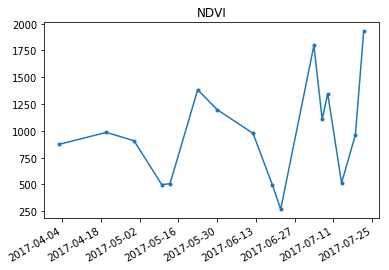

In [15]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame.from_dict(point_timeseries, orient="index")
df.index = pd.to_datetime(df.index)
df.dropna()[0].plot(marker='.', title='NDVI')